In [1]:
%matplotlib inline
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100

In [36]:
from collections import Counter

import tqdm
import corner
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp, gaussian_kde
from sklearn.decomposition import PCA

In [3]:
from exoabc import Simulator, data

In [4]:
period_range = (50, 300)
prad_range = (0.75, 2.5)
depth_range = (0, 1000)
maxn = 2

In [5]:
prefix = "q1_q16"
stlr = data.get_burke_gk(prefix=prefix)
kois = data.get_candidates(stlr=stlr, prefix=prefix)

In [6]:
sim = Simulator(
    stlr,
    period_range[0], period_range[1], 0.0,
    prad_range[0], prad_range[1], -2.0,
    -3.0, np.zeros(maxn),
    release=prefix
)

In [7]:
def compute_stats(catalog):
    m = (period_range[0] <= catalog.koi_period) & (catalog.koi_period <= period_range[1])
    m &= (prad_range[0] <= catalog.koi_prad) & (catalog.koi_prad <= prad_range[1])
    m &= (depth_range[0] <= catalog.koi_depth) & (catalog.koi_depth <= depth_range[1])
    c = catalog[m]
    
    # Multiplicity
    h = Counter(Counter(c.kepid).values())
    hist = np.zeros(maxn, dtype=int)
    for i in range(maxn):
        hist[i] = h.get(i + 1, 0)
    
    return hist, np.array(c.koi_period), np.array(c.koi_depth), np.array(c.koi_duration)

def compute_distances(ds1, ds2):
    norm = max(np.max(ds1[0]), np.max(ds2[0]))
    multi_dist = np.sum((ds1[0] - ds2[0])**2.0) / norm**2
    period_dist = ks_2samp(ds1[1], ds2[1]).statistic
    depth_dist = ks_2samp(ds1[2], ds2[2]).statistic
    
    return multi_dist, period_dist, depth_dist

In [8]:
obs_stats = compute_stats(kois)

In [9]:
def sample(initial=None):
    if initial is None:
        lp = sim.sample_parameters()
        if not np.isfinite(lp):
            return (-np.inf, -np.inf, -np.inf), sim.get_parameters(), sim.state
    else:
        sim.set_parameters(initial)
    pars, state = sim.get_parameters(), sim.state
    df = sim.sample_population()
    if len(df) <= 1:
        return (-np.inf, -np.inf, -np.inf), pars, state
    return compute_distances(obs_stats, compute_stats(df)), pars, state

In [10]:
n = 10000
samples = [sample() for _ in tqdm.tqdm(range(n), total=n)]

In [11]:
distances = np.array([s[0] for s in samples])
m = np.all(np.isfinite(distances), axis=1)
distances = distances[m]
params = np.array([s[1] for s in samples])[m]
states = np.array([s[2] for s in samples])[m]

In [12]:
print(distances)

[[ 0.54132653  0.54073087  0.33193757]
 [ 0.          0.47887324  0.16197183]
 [ 0.28784922  0.33580191  0.16029078]
 ..., 
 [ 0.14882653  0.07844743  0.09564363]
 [ 0.16005102  0.30197854  0.13028169]
 [ 0.08163265  0.27905819  0.12832551]]


In [14]:
model = PCA(1)
model.fit(distances)

PCA(copy=True, n_components=1, whiten=False)

In [15]:
model.components_

array([[-0.92440859, -0.30361515, -0.23083892]])

In [16]:
w = np.abs(model.components_[0])
w /= np.sum(w)
scalar = np.dot(distances, w)

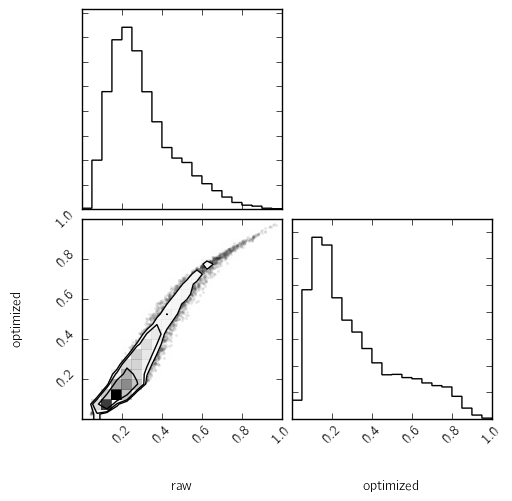

In [17]:
points = np.vstack([np.sum(distances, axis=1) / 3.0, scalar]).T
corner.corner(points, range=[(0, 1), (0, 1)], labels=["raw", "optimized"]);

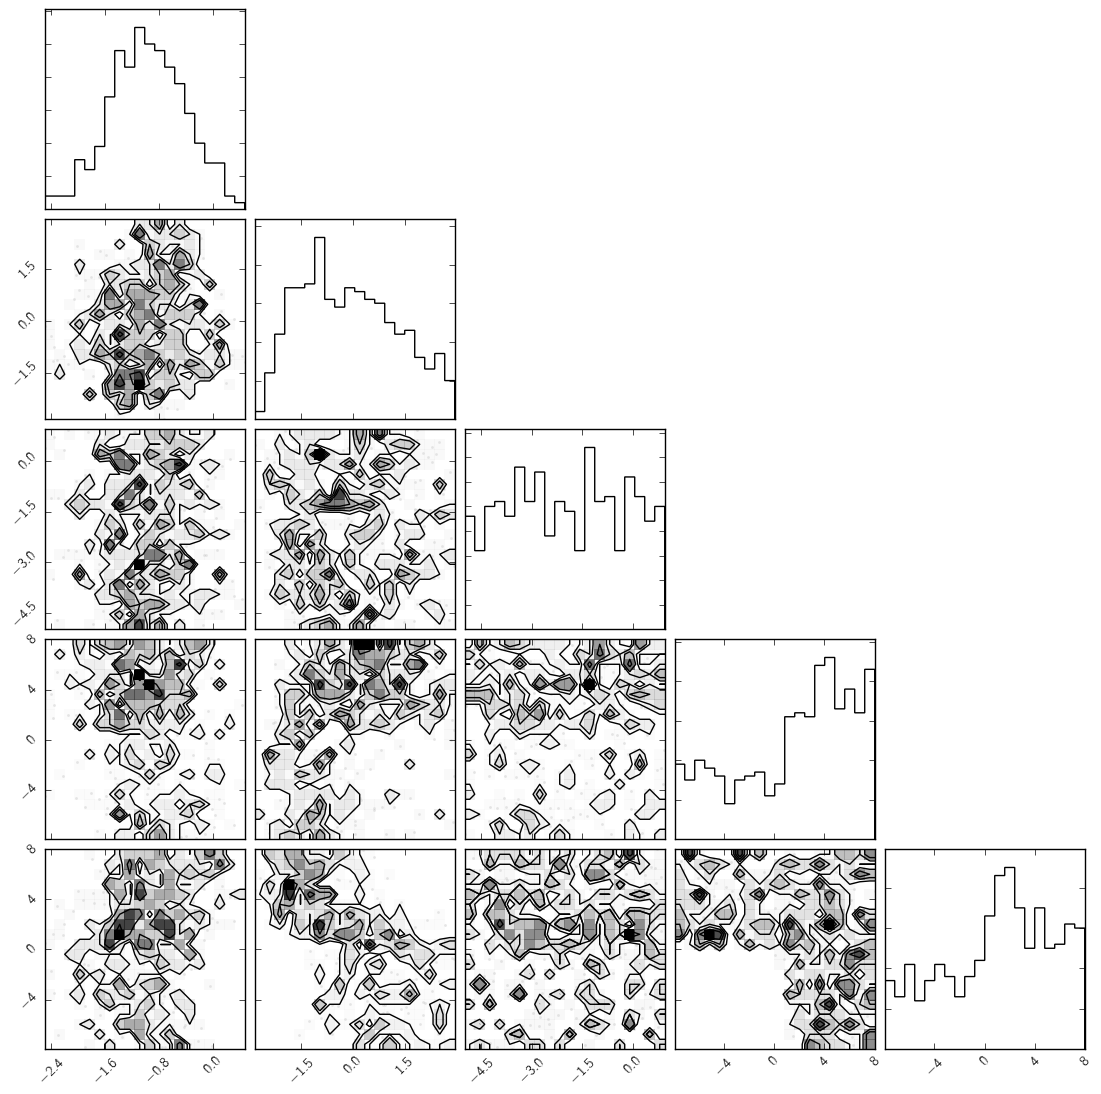

In [18]:
inds = np.argsort(scalar)
corner.corner(params[inds[:500]]);

In [22]:
i = 0
p = np.array(params[inds[i]])
print(p)

sim.set_parameters(p)
sim.state = states[inds[i]]
pop = sim.sample_population()
sim_stats = compute_stats(pop)
sim_stats[0], obs_stats[0]

[-1.06410656 -0.61747256 -4.74349666  4.86422077 -4.41431786]


(array([129,   0]), array([140,   1]))

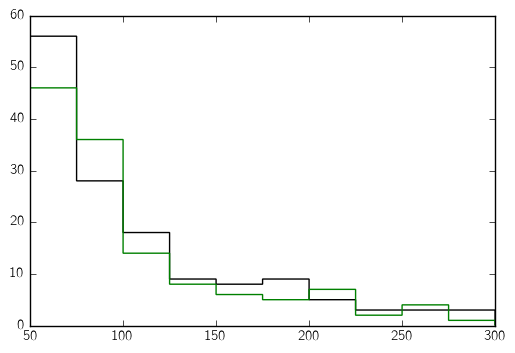

In [23]:
plt.hist(obs_stats[1], range=period_range, histtype="step", color="k")
plt.hist(sim_stats[1], range=period_range, histtype="step", color="g");

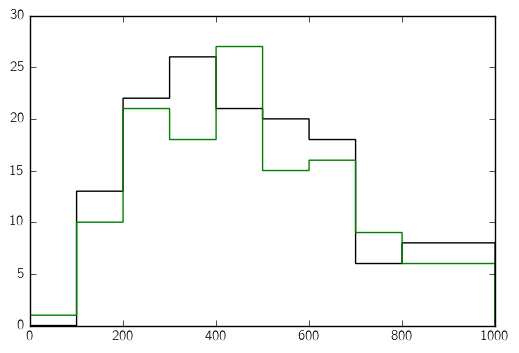

In [24]:
plt.hist(obs_stats[2], range=depth_range, histtype="step", color="k")
plt.hist(sim_stats[2], range=depth_range, histtype="step", color="g");

In [50]:
kde = gaussian_kde(new_params[new_inds].T)

In [ ]:
new_n = 10000
new_x = kde.resample(new_n)
new_logpdfs = kde.logpdf(new_x)
new_samples = [sample(x) for x in tqdm.tqdm(new_x.T, total=new_n)]

  1%|▏         | 137/10000 [00:18<22:39,  7.26it/s]

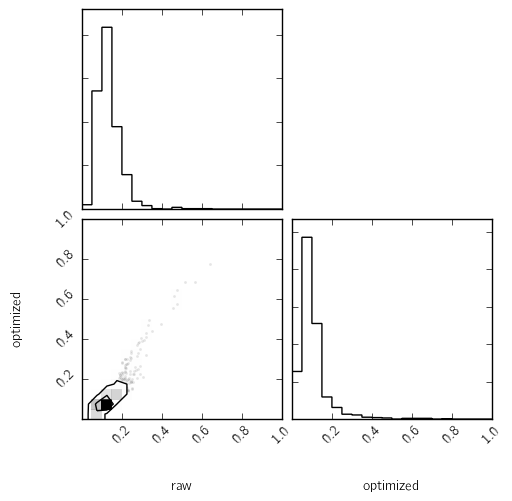

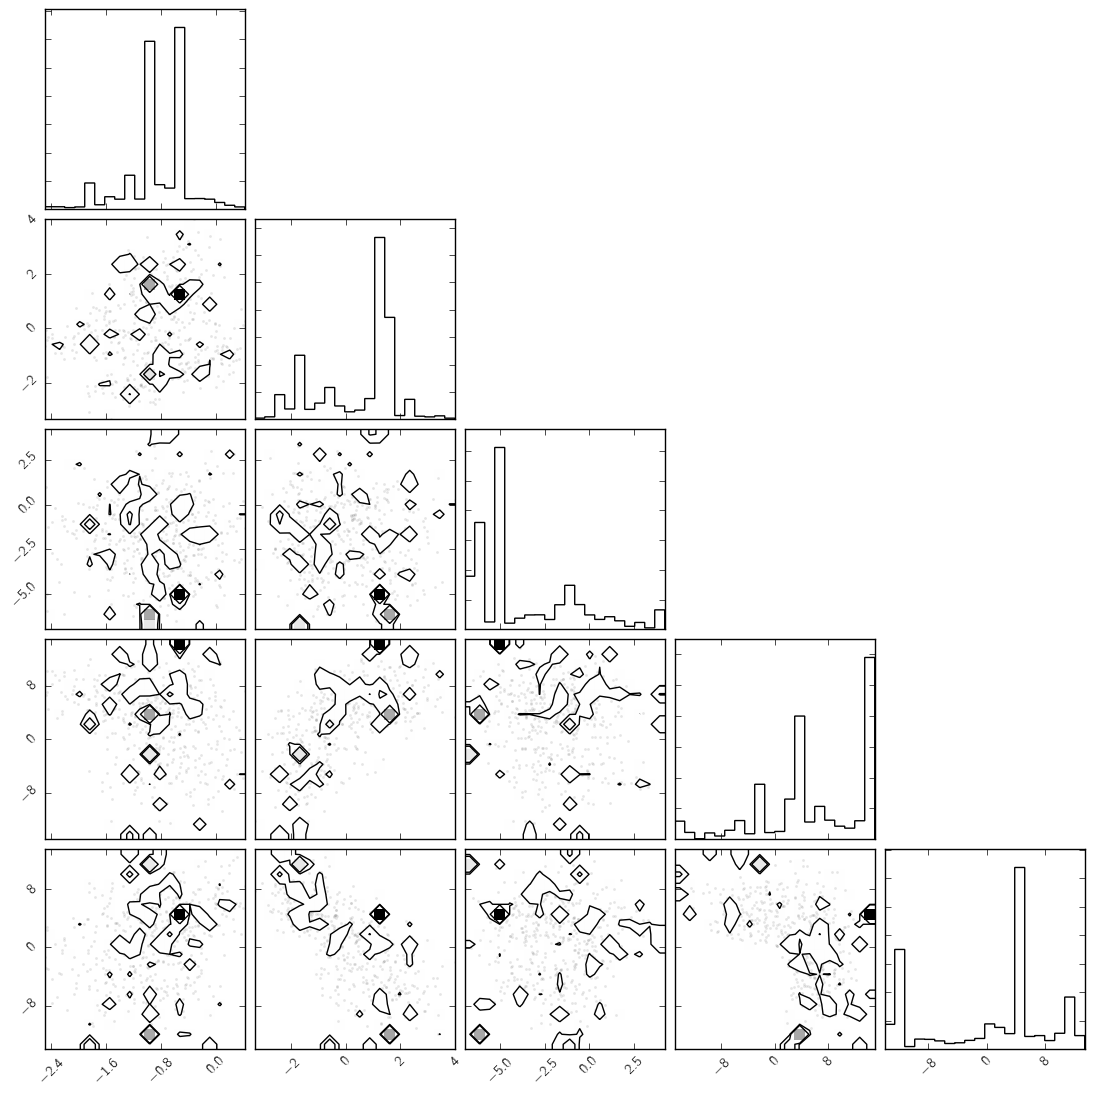

In [49]:
new_distances = np.array([s[0] for s in new_samples])
m = np.all(np.isfinite(new_distances), axis=1)
new_distances = new_distances[m]
new_params = np.array([s[1] for s in new_samples])[m]
new_states = np.array([s[2] for s in new_samples])[m]

new_model = PCA(1)
new_model.fit(new_distances)

new_w = np.abs(new_model.components_[0])
new_w /= np.sum(new_w)
new_scalar = np.dot(new_distances, new_w)

points = np.vstack([np.sum(new_distances, axis=1) / 3.0, new_scalar]).T
corner.corner(points, range=[(0, 1), (0, 1)], labels=["raw", "optimized"]);

new_inds = np.argsort(new_scalar)[:500]
weights = new_logpdfs[new_inds]
weights = np.exp(np.max(weights) - weights)
corner.corner(new_params[new_inds], weights=weights);